In [2]:
import sys
import numpy as np
import pandas as pd
sys.path.insert(0, "../utils/")
from data_loader import load_data
from scipy.stats import ttest_ind 
from scipy.stats import f_oneway
import pathlib

In [5]:
latent_dir = pathlib.Path("../2.train-VAE/results/latent_df.parquet").resolve()
latent_df = pd.read_parquet(latent_dir)
metadata_dir = pathlib.Path(".././0.data-download/data/metadata_df.parquet").resolve()
metadata_df = pd.read_parquet(metadata_dir)
data_dir = pathlib.Path("../0.data-download/data/").resolve()
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")
gsea_results_dir = pathlib.Path("../3.analysis/results/combined_gsea_results.parquet.gz").resolve()
gsea_results_df = pd.read_parquet(gsea_results_dir)
all_GSEA_results_dir = pathlib.Path("../3.analysis/results/all_gsea_results.parquet.gz").resolve()
all_GSEA_results_df = pd.read_parquet(all_GSEA_results_dir)
significant_gsea_dir = pathlib.Path("../3.analysis/results/significant_gsea_results.parquet.gz")
significant_gsea_df = pd.read_parquet(significant_gsea_dir)

(958, 37)


In [3]:
# Creating categorized lists of sample IDs used in BVAE training
# note that 10 of the 912 used samples have Unknown Sex

ped_ids = metadata_df.query("AgeCategory == 'Pediatric'").ModelID.tolist()
adult_ids = metadata_df.query("AgeCategory == 'Adult'").ModelID.tolist()
male_ids = metadata_df.query("Sex == 'Male'").ModelID.tolist()
female_ids = metadata_df.query("Sex == 'Female'").ModelID.tolist()
ped_male_ids = metadata_df.query("AgeCategory == 'Pediatric'").query("Sex == 'Male'").ModelID.tolist()
adult_male_ids = metadata_df.query("AgeCategory == 'Adult'").query("Sex == 'Male'").ModelID.tolist()
ped_female_ids = metadata_df.query("AgeCategory == 'Pediatric'").query("Sex == 'Female'").ModelID.tolist()
adult_female_ids = metadata_df.query("AgeCategory == 'Adult'").query("Sex == 'Female'").ModelID.tolist()

In [4]:
# Generating latent dataframes for each category and dropping the id column to prep for t tests
def generate_latent_df(latent_df, category_ids):
    """
    Generate a latent DataFrame filtered by category IDs and drop the 'ModelID' column.

    Parameters:
    latent_df (pd.DataFrame): The original DataFrame containing latent variables.
    category_ids (list): The list of ModelIDs to filter the DataFrame by.

    Returns:
    pd.DataFrame: The filtered DataFrame with the 'ModelID' column dropped.
    """
    filtered_df = latent_df[latent_df['ModelID'].isin(category_ids)].copy()
    filtered_df_float = filtered_df.drop(columns=["ModelID"])
    filtered_df_float.reset_index(drop=True, inplace=True)
    return filtered_df, filtered_df_float


# Usage for each category
adult_latent_df, adult_latent_df_float = generate_latent_df(latent_df, adult_ids)
ped_latent_df, ped_latent_df_float = generate_latent_df(latent_df, ped_ids)
male_latent_df, male_latent_df_float = generate_latent_df(latent_df, male_ids)
female_latent_df, female_latent_df_float = generate_latent_df(latent_df, female_ids)
ped_male_latent_df, ped_male_latent_df_float = generate_latent_df(latent_df, ped_male_ids)
adult_male_latent_df, adult_male_latent_df_float = generate_latent_df(latent_df, adult_male_ids)
ped_female_latent_df, ped_female_latent_df_float = generate_latent_df(latent_df, ped_female_ids)
adult_female_latent_df, adult_female_latent_df_float = generate_latent_df(latent_df, adult_female_ids)

In [5]:
# t tests comparing adult vs ped for each latent dimension

t_test_adult_vs_ped = ttest_ind(adult_latent_df_float, ped_latent_df_float)
t_test_adult_vs_ped = pd.DataFrame(t_test_adult_vs_ped).T
t_test_adult_vs_ped.columns = ["t_stat", "p_value"]
t_test_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
t_test_adult_vs_ped['latent_feature'] = t_test_adult_vs_ped.index + 1
# Remove rows with NaN values
t_test_adult_vs_ped = t_test_adult_vs_ped.dropna()
print(t_test_adult_vs_ped.shape)

t_test_adult_vs_ped.head(50)

(29, 4)


,t_stat,p_value,comparison,latent_feature
1,-5.819086,8.068576e-09,Adult vs Pediatric,2
2,0.520462,6.028619e-01,Adult vs Pediatric,3
4,-4.018735,6.310978e-05,Adult vs Pediatric,5
5,0.418699,6.755301e-01,Adult vs Pediatric,6
6,1.196502,2.317973e-01,Adult vs Pediatric,7
7,0.418699,6.755301e-01,Adult vs Pediatric,8
8,2.225090,2.630792e-02,Adult vs Pediatric,9
9,-4.609868,4.575702e-06,Adult vs Pediatric,10
10,-8.872383,3.462139e-18,Adult vs Pediatric,11
11,0.587170,5.572283e-01,Adult vs Pediatric,12


In [6]:
# t tests comparing male vs female for each latent dimension

t_test_male_vs_female = ttest_ind(male_latent_df_float, female_latent_df_float)
t_test_male_vs_female = pd.DataFrame(t_test_male_vs_female).T
t_test_male_vs_female.columns = ["t_stat", "p_value"]
t_test_male_vs_female['comparison'] = 'Male vs Female'
t_test_male_vs_female['latent_feature'] = t_test_male_vs_female.index + 1
# Remove rows with NaN values
t_test_male_vs_female = t_test_male_vs_female.dropna()
print(t_test_male_vs_female.shape)

t_test_male_vs_female.head()

(29, 4)


,t_stat,p_value,comparison,latent_feature
1,1.608580,0.108042,Male vs Female,2
2,0.507042,0.612243,Male vs Female,3
4,1.635117,0.102357,Male vs Female,5
5,0.869115,0.385005,Male vs Female,6
6,-0.215909,0.829105,Male vs Female,7


In [7]:
# t tests comparing adult male vs ped male for each latent dimension

t_test_adult_male_vs_ped_male = ttest_ind(ped_male_latent_df_float, adult_male_latent_df_float)
t_test_adult_male_vs_ped_male = pd.DataFrame(t_test_adult_male_vs_ped_male).T
t_test_adult_male_vs_ped_male.columns = ["t_stat", "p_value"]
t_test_adult_male_vs_ped_male['comparison'] = 'Adult Male vs Pediatric Male'
t_test_adult_male_vs_ped_male['latent_feature'] = t_test_adult_male_vs_ped_male.index + 1
# Remove rows with NaN values
t_test_adult_male_vs_ped_male = t_test_adult_male_vs_ped_male.dropna()
print(t_test_adult_male_vs_ped_male.shape)

t_test_adult_male_vs_ped_male.head()

(29, 4)


,t_stat,p_value,comparison,latent_feature
1,3.370114,0.000805,Adult Male vs Pediatric Male,2
2,-0.413646,0.679298,Adult Male vs Pediatric Male,3
4,2.334619,0.019930,Adult Male vs Pediatric Male,5
5,-0.413646,0.679298,Adult Male vs Pediatric Male,6
6,-0.447143,0.654952,Adult Male vs Pediatric Male,7


In [8]:
# t tests comparing adult female vs ped female for each latent dimension

t_test_adult_female_vs_ped_female = ttest_ind(ped_female_latent_df_float, adult_female_latent_df_float)
t_test_adult_female_vs_ped_female = pd.DataFrame(t_test_adult_female_vs_ped_female).T
t_test_adult_female_vs_ped_female.columns = ["t_stat", "p_value"]
t_test_adult_female_vs_ped_female['comparison'] = 'Adult Female vs Pediatric Female'
t_test_adult_female_vs_ped_female['latent_feature'] = t_test_adult_female_vs_ped_female.index + 1
# Remove rows with NaN values
t_test_adult_female_vs_ped_female = t_test_adult_female_vs_ped_female.dropna()
print(t_test_adult_female_vs_ped_female.shape)

t_test_adult_female_vs_ped_female.head()

(27, 4)


,t_stat,p_value,comparison,latent_feature
1,4.877120,0.000002,Adult Female vs Pediatric Female,2
2,-0.398450,0.690508,Adult Female vs Pediatric Female,3
4,3.346269,0.000895,Adult Female vs Pediatric Female,5
6,-1.138063,0.255765,Adult Female vs Pediatric Female,7
8,-1.580411,0.114791,Adult Female vs Pediatric Female,9


In [9]:
# t tests comparing ped male vs ped female for each latent dimension

t_test_ped_male_vs_ped_female = ttest_ind(ped_female_latent_df_float, ped_male_latent_df_float)
t_test_ped_male_vs_ped_female = pd.DataFrame(t_test_ped_male_vs_ped_female).T
t_test_ped_male_vs_ped_female.columns = ["t_stat", "p_value"]
t_test_ped_male_vs_ped_female['comparison'] = 'Pediatric Male vs Pediatric Female'
t_test_ped_male_vs_ped_female['latent_feature'] = t_test_ped_male_vs_ped_female.index + 1
# Remove rows with NaN values
t_test_ped_male_vs_ped_female = t_test_ped_male_vs_ped_female.dropna()
print(t_test_ped_male_vs_ped_female.shape)

t_test_ped_male_vs_ped_female.head()

(24, 4)


,t_stat,p_value,comparison,latent_feature
1,0.644385,0.520436,Pediatric Male vs Pediatric Female,2
4,0.391238,0.696247,Pediatric Male vs Pediatric Female,5
6,-0.841019,0.401847,Pediatric Male vs Pediatric Female,7
8,-0.658667,0.511248,Pediatric Male vs Pediatric Female,9
9,0.318222,0.750816,Pediatric Male vs Pediatric Female,10


In [10]:
# t tests comparing adult male vs adult female for each latent dimension

t_test_adult_male_vs_adult_female = ttest_ind(adult_female_latent_df_float, adult_male_latent_df_float)
t_test_adult_male_vs_adult_female = pd.DataFrame(t_test_adult_male_vs_adult_female).T
t_test_adult_male_vs_adult_female.columns = ["t_stat", "p_value"]
t_test_adult_male_vs_adult_female['comparison'] = 'Adult Male vs Adult Female'
t_test_adult_male_vs_adult_female['latent_feature'] = t_test_adult_male_vs_adult_female.index + 1
# Remove rows with NaN values
t_test_adult_male_vs_adult_female = t_test_adult_male_vs_adult_female.dropna()
print(t_test_adult_male_vs_adult_female.shape)

t_test_adult_male_vs_adult_female.head()

(29, 4)


,t_stat,p_value,comparison,latent_feature
1,-1.930436,0.053901,Adult Male vs Adult Female,2
2,-0.513152,0.607985,Adult Male vs Adult Female,3
4,-1.871488,0.061637,Adult Male vs Adult Female,5
5,-0.873690,0.382546,Adult Male vs Adult Female,6
6,0.432232,0.665687,Adult Male vs Adult Female,7


In [11]:
# Combining and saving t test results
t_test_results_df = pd.concat([
    t_test_adult_vs_ped, 
    t_test_male_vs_female, 
    t_test_adult_male_vs_ped_male, 
    t_test_adult_female_vs_ped_female, 
    t_test_ped_male_vs_ped_female, 
    t_test_adult_male_vs_adult_female
]).reset_index(drop=True)
t_test_results_dir = pathlib.Path("./results/t_test_results.tsv")
t_test_results_df.to_parquet(t_test_results_dir)

# sort to show most significant p-values
t_test_results_df.sort_values(by='p_value', ascending = True)

,t_stat,p_value,comparison,latent_feature
8,-8.872383,3.462139e-18,Adult vs Pediatric,11
27,-7.207833,1.153410e-12,Adult vs Pediatric,33
93,7.031221,8.727330e-12,Adult Female vs Pediatric Female,11
12,-6.872249,1.138528e-11,Adult vs Pediatric,15
16,-6.715639,3.208523e-11,Adult vs Pediatric,20
...,...,...,...,...
130,0.261988,7.937363e-01,Pediatric Male vs Pediatric Female,27
33,-0.215909,8.291048e-01,Male vs Female,7
133,0.211380,8.329143e-01,Pediatric Male vs Pediatric Female,30
123,0.179391,8.579040e-01,Pediatric Male vs Pediatric Female,16


In [12]:
# ANOVA Testing
f_statistic, p_value = f_oneway(adult_male_latent_df_float, ped_male_latent_df_float, adult_female_latent_df_float, ped_female_latent_df_float)
anova_df = pd.DataFrame({'f_stat': f_statistic.tolist(), 'p_value': p_value.tolist()})
anova_df['latent_feature'] = anova_df.index + 1
# Remove rows with NaN values
anova_df = anova_df.dropna()
anova_df

/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:605: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


,f_stat,p_value,latent_feature
1,12.162348,8.180283e-08,2
2,0.187467,9.049537e-01,3
4,6.472227,2.450524e-04,5
5,0.351410,7.881407e-01,6
6,0.603223,6.130013e-01,7
7,0.351410,7.881407e-01,8
8,1.520637,2.075822e-01,9
9,8.244422,2.033620e-05,10
10,27.787260,3.182992e-17,11
11,0.164663,9.201810e-01,12


In [13]:
#Lung cancer in adults vs neuroblastoma in peds comparison

# Extract Neuroblastoma model IDs from the model dataframe
NB_ids = model_df.query("OncotreePrimaryDisease == 'Neuroblastoma'").ModelID.tolist()

# Create a copy of the pediatric latent space dataframe
ped_NB_latent_df = ped_latent_df.copy()

# Filter the pediatric latent dataframe to include only Neuroblastoma models
for index, row in ped_NB_latent_df.iterrows():
    if row['ModelID'] not in NB_ids:
        ped_NB_latent_df.drop(index, inplace=True)

# Drop the 'ModelID' column from the filtered pediatric latent dataframe
# and reset the index
ped_NB_latent_float_df = ped_NB_latent_df.drop(columns=["ModelID"])
ped_NB_latent_float_df.reset_index(drop=True, inplace=True)

# Extract Non-Small Cell Lung Cancer (NSCLC) model IDs from the model dataframe
LC_ids = model_df.query("OncotreePrimaryDisease == 'Non-Small Cell Lung Cancer'").ModelID.tolist()

# Create a copy of the adult latent space dataframe
adult_LC_latent_df = adult_latent_df.copy()

# Filter the adult latent dataframe to include only NSCLC models
for index, row in adult_LC_latent_df.iterrows():
    if row['ModelID'] not in LC_ids:
        adult_LC_latent_df.drop(index, inplace=True)

# Drop the 'ModelID' column from the filtered adult latent dataframe
# and reset the index
adult_LC_latent_float_df = adult_LC_latent_df.drop(columns=["ModelID"])
adult_LC_latent_float_df.reset_index(drop=True, inplace=True)

In [14]:
# t tests comparing Lung Cancer in adult vs Neuroblastoma in ped for each latent dimension

t_test_diff_adult_vs_ped = ttest_ind(adult_LC_latent_float_df, ped_NB_latent_float_df)
t_test_diff_adult_vs_ped = pd.DataFrame(t_test_diff_adult_vs_ped).T
t_test_diff_adult_vs_ped.columns = ["t_stat", "p_value"]
t_test_diff_adult_vs_ped['comparison'] = 'Lung Cancer vs Neuroblastoma'
t_test_diff_adult_vs_ped['latent_feature'] = t_test_diff_adult_vs_ped.index + 1
# Remove rows with NaN values
t_test_diff_adult_vs_ped = t_test_diff_adult_vs_ped.dropna()
print(t_test_diff_adult_vs_ped.shape)

t_test_diff_adult_vs_ped.sort_values(by = 'p_value', ascending= True)

(23, 4)


,t_stat,p_value,comparison,latent_feature
10,-7.284999,4.642513e-11,Lung Cancer vs Neuroblastoma,11
32,-5.707933,9.351197e-08,Lung Cancer vs Neuroblastoma,33
14,-5.644047,1.250126e-07,Lung Cancer vs Neuroblastoma,15
19,-5.242069,7.468334e-07,Lung Cancer vs Neuroblastoma,20
34,-5.233598,7.749075e-07,Lung Cancer vs Neuroblastoma,35
18,-5.028229,1.876633e-06,Lung Cancer vs Neuroblastoma,19
27,-4.749866,6.023931e-06,Lung Cancer vs Neuroblastoma,28
21,-4.562941,1.289247e-05,Lung Cancer vs Neuroblastoma,22
16,-4.481993,1.782073e-05,Lung Cancer vs Neuroblastoma,17
1,-3.801948,2.331823e-04,Lung Cancer vs Neuroblastoma,2


In [15]:
# Obtaining shared cancer types in ped and adult
adult_types = model_df.query("AgeCategory == 'Adult'").OncotreePrimaryDisease.tolist()
adult_types = [x for x in adult_types if adult_types.count(x) >= 5]
adult_types = list(set(adult_types))

ped_types = model_df.query("AgeCategory == 'Pediatric'").OncotreePrimaryDisease.tolist()
ped_types = [x for x in ped_types if ped_types.count(x) >= 5]
ped_types = list(set(ped_types))

all_types = set(adult_types) | set(ped_types)

shared_types = set(adult_types) & set(ped_types)
shared_types

{'Acute Myeloid Leukemia', 'Ewing Sarcoma', 'Mature B-Cell Neoplasms'}

In [16]:
# Comparing the shared cancer types
# Initialize a list to store the t-test results for each shared cancer type
comp_dfs = []

# Iterate over each cancer type shared between adult and pediatric datasets
for cancer_type in shared_types:
    # Extract the model IDs for the current cancer type from the model dataframe
    type_ids = model_df.query("OncotreePrimaryDisease == " + "'" + cancer_type + "'").ModelID.tolist()

    # Filter the pediatric latent dataframe to include only models of the current cancer type
    ped_type_latent_df = ped_latent_df.copy()
    ped_type_latent_df = ped_latent_df[ped_latent_df['ModelID'].isin(type_ids)].copy()

    # Drop the 'ModelID' column and reset the index in the pediatric latent dataframe
    ped_type_latent_float_df = ped_type_latent_df.drop(columns=["ModelID"])
    ped_type_latent_float_df.reset_index(drop=True, inplace=True)

    # Filter the adult latent dataframe to include only models of the current cancer type
    adult_type_latent_df = adult_latent_df.copy()
    adult_type_latent_df = adult_latent_df[adult_latent_df['ModelID'].isin(type_ids)].copy()

    # Drop the 'ModelID' column and reset the index in the adult latent dataframe
    adult_type_latent_float_df = adult_type_latent_df.drop(columns=["ModelID"])
    adult_type_latent_float_df.reset_index(drop=True, inplace=True)

    # Perform a t-test comparing the latent features between adult and pediatric datasets
    t_test_type_adult_vs_ped = ttest_ind(adult_type_latent_float_df, ped_type_latent_float_df)

    # Convert the t-test results to a DataFrame and add additional information
    t_test_type_adult_vs_ped = pd.DataFrame(t_test_type_adult_vs_ped).T
    t_test_type_adult_vs_ped.columns = ["t_stat", "p_value"]
    t_test_type_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
    t_test_type_adult_vs_ped['cancer_type'] = cancer_type
    t_test_type_adult_vs_ped['latent_feature'] = t_test_type_adult_vs_ped.index + 1

    # Append the t-test results for the current cancer type to the list
    comp_dfs.append(t_test_type_adult_vs_ped)

# Concatenate all the t-test results into a single DataFrame
t_test_type_results_df = pd.concat(comp_dfs).reset_index(drop=True)

# Remove any rows with NaN values from the results
t_test_type_results_df = t_test_type_results_df.dropna()

# Sort the t-test results by the p-value in ascending order
t_test_type_results_df.sort_values(by='p_value', ascending=True)

,t_stat,p_value,comparison,cancer_type,latent_feature
48,2.800765,0.009912,Adult vs Pediatric,Acute Myeloid Leukemia,13
51,2.415355,0.023699,Adult vs Pediatric,Acute Myeloid Leukemia,16
12,-1.685739,0.098337,Adult vs Pediatric,Mature B-Cell Neoplasms,13
58,1.603020,0.122011,Adult vs Pediatric,Acute Myeloid Leukemia,23
52,1.573365,0.128726,Adult vs Pediatric,Acute Myeloid Leukemia,17
...,...,...,...,...,...
57,0.063887,0.949589,Adult vs Pediatric,Acute Myeloid Leukemia,22
70,-0.039196,0.969058,Adult vs Pediatric,Acute Myeloid Leukemia,35
25,0.031918,0.974669,Adult vs Pediatric,Mature B-Cell Neoplasms,26
90,-0.005949,0.995310,Adult vs Pediatric,Ewing Sarcoma,19


In [28]:
# Prepare a DataFrame to store ANOVA results for multiple pathways
anova_results = []

# Add "z_" prefix to the latent dimensions in the t-test DataFrame
t_test_adult_vs_ped['z_dim'] = 'z_' + t_test_adult_vs_ped['latent_feature'].astype(str)
t_test_adult_vs_ped['group'] = t_test_adult_vs_ped['t_stat'].apply(lambda x: 'Adult' if x > 0 else 'Pediatric')

# Filter significant latent features
significant_latent_features = t_test_adult_vs_ped[t_test_adult_vs_ped['p_value'] < 0.05]

# Add the 'z_dim' column if not already added
significant_latent_features.loc[:, 'z_dim'] = 'z_' + significant_latent_features['latent_feature'].astype(str)


# Loop through all unique pathways (Terms) in the GSEA DataFrame
for pathway in gsea_results_df['Term'].unique():
    # Filter for the pathway
    filtered_gsea_df = gsea_results_df[gsea_results_df['Term'] == pathway]
    
    # Further filter by significant latent features
    filtered_gsea_df = filtered_gsea_df[filtered_gsea_df['z_dim'].isin(significant_latent_features['z_dim'])]
    
    # Merge GSEA DataFrame with t-test DataFrame to get group information
    merged_df = pd.merge(filtered_gsea_df, significant_latent_features[['z_dim', 'group']], on='z_dim', how='inner')

    # Group by 'group' and collect ES values
    grouped_data = merged_df.groupby('group')['es'].apply(list)

    # Ensure we have data for both groups
    if len(grouped_data) == 2 and all(len(vals) > 1 for vals in grouped_data):
        # Perform ANOVA
        f_statistic, p_value = f_oneway(*grouped_data)

        # Determine which group has higher enrichment score
        adult_mean = np.mean(grouped_data['Adult'])
        pediatric_mean = np.mean(grouped_data['Pediatric'])
        higher_group = 'Adult' if adult_mean > pediatric_mean else 'Pediatric'

        # Store results
        anova_results.append({
            'Pathway': pathway,
            'F-statistic': f_statistic,
            'p-value': p_value,
            'Higher in': higher_group
        })

# Convert the results to a DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Apply a significance threshold (e.g., p < 0.05)
significant_anova_results_df = anova_results_df[anova_results_df['p-value'] < 0.05]

anova_dir = pathlib.Path("./results/anova_results.csv")
significant_anova_results_df.to_csv(anova_dir)

# Display significant pathways
significant_anova_results_df.sort_values(by='F-statistic', key=abs, ascending = False).head(50)

,Pathway,F-statistic,p-value,Higher in
226,Metabolism R-HSA-1430728,28.203411,0.000004,Adult
194,Metabolism Of Vitamins And Cofactors R-HSA-196854,26.562594,0.000006,Adult
176,EPHB-mediated Forward Signaling R-HSA-3928662,19.197657,0.000077,Pediatric
180,Mitochondrial Translation Termination R-HSA-54...,14.879219,0.000388,Adult
240,Prolonged ERK Activation Events R-HSA-169893,14.575696,0.000437,Pediatric
117,Cytoprotection By HMOX1 R-HSA-9707564,13.815088,0.000590,Adult
250,Citric Acid Cycle (TCA Cycle) R-HSA-71403,13.736310,0.000609,Adult
193,Mitochondrial Translation Initiation R-HSA-536...,12.247656,0.001117,Adult
272,Frs2-mediated Activation R-HSA-170968,11.369218,0.001613,Pediatric
373,Diseases Associated With N-glycosylation Of Pr...,11.261227,0.001688,Pediatric


/tmp/ipykernel_6009/1625018463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_anova_results_df.rename(columns={'Pathway': 'Term'}, inplace=True)


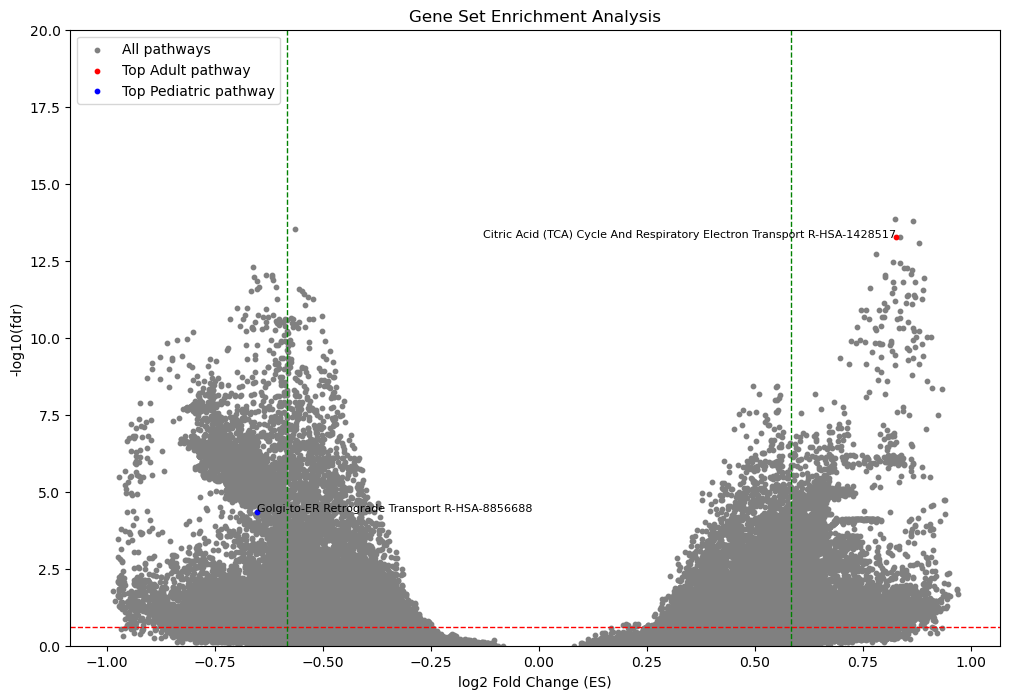

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25

# Merge GSEA results with ANOVA results based on the 'Pathway' column
significant_anova_results_df.rename(columns={'Pathway': 'Term'}, inplace=True)
merged_df = significant_gsea_df.merge(significant_anova_results_df[['Term', 'Higher in', 'F-statistic']], on='Term', how='left')

# Define masks for adult and pediatric pathways
adult_mask = merged_df['Higher in'] == 'Adult'
pediatric_mask = merged_df['Higher in'] == 'Pediatric'

# Sort by the absolute value of NES and select the top 5 adult and top 5 pediatric pathways
top_adult = merged_df[adult_mask].loc[merged_df[adult_mask]['nes'].abs().nlargest(1).index]
top_pediatric = merged_df[pediatric_mask].loc[merged_df[pediatric_mask]['nes'].abs().nlargest(1).index]

# Combine the top pathways
top_pathways_df = pd.concat([top_adult, top_pediatric])

# Create the plot
plt.figure(figsize=(12, 8))

# Plot all pathways in grey
plt.scatter(x=all_GSEA_results_df['es'], 
            y=all_GSEA_results_df['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='grey', label='All pathways')

# Plot top adult pathways in red
plt.scatter(x=top_adult['es'], 
            y=top_adult['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='red', label='Top Adult pathway')

# Plot top pediatric pathways in blue
plt.scatter(x=top_pediatric['es'], 
            y=top_pediatric['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='blue', label='Top Pediatric pathway')

# Add LFC and FDR cut-off lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)

# Add labels for the top pathways

for i in top_pathways_df.index:
    es_value = top_pathways_df.at[i, 'es']
    fdr_value = top_pathways_df.at[i, 'fdr']
    pathway_label = top_pathways_df.at[i, 'Term']
    
    # Add the label for each point
    plt.text((es_value), (-np.log10(fdr_value)), pathway_label, fontsize=8, ha='right' if es_value > 0 else 'left')


# Label axes and add title
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0, 20)
plt.title('Gene Set Enrichment Analysis')

# Add legend
plt.legend()

# Save the figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/gsea_top_labeled.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)

# Show the plot
plt.show()


In [30]:
# Prepare a DataFrame to store ANOVA results for multiple pathways
anova_results = []

# Loop through each OncotreePrimaryDisease type in the dataset
for disease in model_df['OncotreePrimaryDisease'].unique():
    # Extract model IDs for the current disease
    disease_ids = model_df.query(f"OncotreePrimaryDisease == '{disease}'").ModelID.tolist()

    # Create a copy of the latent space dataframe (either adult or pediatric as applicable)
    latent_df = latent_df.copy()  # Use the appropriate dataframe here (adult or pediatric)

    # Filter the latent dataframe to include only the current disease models
    disease_latent_df = latent_df[latent_df['ModelID'].isin(disease_ids)]

    # Drop the 'ModelID' column and reset the index
    disease_latent_float_df = disease_latent_df.drop(columns=["ModelID"]).reset_index(drop=True)

    # Extract model IDs for the rest of the dataset
    other_ids = model_df.query(f"OncotreePrimaryDisease != '{disease}'").ModelID.tolist()

    # Filter the latent dataframe to include only the models not in the current disease
    other_latent_df = latent_df[latent_df['ModelID'].isin(other_ids)]
    other_latent_float_df = other_latent_df.drop(columns=["ModelID"]).reset_index(drop=True)

    # Perform t-tests comparing current disease vs the rest for each latent dimension
    t_test_results = ttest_ind(disease_latent_float_df, other_latent_float_df)
    t_test_results_df = pd.DataFrame(t_test_results).T
    t_test_results_df.columns = ["t_stat", "p_value"]
    t_test_results_df['comparison'] = f"{disease} vs Rest"
    t_test_results_df['latent_feature'] = t_test_results_df.index + 1
    t_test_results_df['z_dim'] = 'z_' + t_test_results_df['latent_feature'].astype(str)
    t_test_results_df['group'] = t_test_results_df['t_stat'].apply(lambda x: disease if x > 0 else 'Rest')

    # Filter significant latent features
    significant_latent_features = t_test_results_df[t_test_results_df['p_value'] < 0.05]

    # Loop through all unique pathways (Terms) in the GSEA DataFrame
    for pathway in gsea_results_df['Term'].unique():
        # Filter for the pathway
        filtered_gsea_df = gsea_results_df[gsea_results_df['Term'] == pathway]
        
        # Further filter by significant latent features
        filtered_gsea_df = filtered_gsea_df[filtered_gsea_df['z_dim'].isin(significant_latent_features['z_dim'])]
        
        # Merge GSEA DataFrame with t-test DataFrame to get group information
        merged_df = pd.merge(filtered_gsea_df, significant_latent_features[['z_dim', 'group']], on='z_dim', how='inner')

        # Group by 'group' and collect ES values
        grouped_data = merged_df.groupby('group')['es'].apply(list)

        # Ensure we have data for both groups
        if len(grouped_data) == 2 and all(len(vals) > 1 for vals in grouped_data):
            # Perform ANOVA
            f_statistic, p_value = f_oneway(*grouped_data)

            # Determine which group has higher enrichment score
            disease_mean = np.mean(grouped_data[disease])
            rest_mean = np.mean(grouped_data['Rest'])
            higher_group = disease if disease_mean > rest_mean else 'Other Types'

            # Store results
            anova_results.append({
                'Cancer Type': disease,
                'Pathway': pathway,
                'F-statistic': f_statistic,
                'p-value': p_value,
                'Higher in': higher_group
            })

# Convert the results to a DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Apply a significance threshold (e.g., p < 0.05)
significant_anova_results_df = anova_results_df[anova_results_df['p-value'] < 0.05]

# Save the results to a CSV file
anova_dir = pathlib.Path("./results/cancer_type_anova_results.csv")
significant_anova_results_df.to_csv(anova_dir, index=False)

# Display significant pathways
significant_anova_results_df.sort_values(by='F-statistic', key=abs, ascending=False).head(50)

/tmp/ipykernel_6009/3555105494.py:26: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  t_test_results = ttest_ind(disease_latent_float_df, other_latent_float_df)
/tmp/ipykernel_6009/3555105494.py:26: SmallSampleWarning: All axis-slices of one or more sample arguments are too small; all elements of returned arrays will be NaN. See documentation for sample size requirements.
  t_test_results = ttest_ind(disease_latent_float_df, other_latent_float_df)


,Cancer Type,Pathway,F-statistic,p-value,Higher in
25877,Nerve Sheath Tumor,Pre-NOTCH Transcription And Translation R-HSA-...,28013.124686,3.569564e-05,Nerve Sheath Tumor
25831,Nerve Sheath Tumor,Pre-NOTCH Expression And Processing R-HSA-1912422,20611.713921,4.851257e-05,Nerve Sheath Tumor
25867,Nerve Sheath Tumor,E2F-enabled Inhibition Of Pre-Replication Comp...,2454.053307,4.072402e-04,Other Types
18385,Merkel Cell Carcinoma,Nephrin Family Interactions R-HSA-373753,1689.366345,2.094072e-06,Merkel Cell Carcinoma
25549,Nerve Sheath Tumor,PTK6 Regulates Cell Cycle R-HSA-8849470,1536.109313,6.503603e-04,Other Types
25435,Nerve Sheath Tumor,Transcriptional Regulation By TP53 R-HSA-3700989,828.977284,1.204127e-03,Nerve Sheath Tumor
25370,Nerve Sheath Tumor,Cohesin Loading Onto Chromatin R-HSA-2470946,755.731754,1.320600e-03,Nerve Sheath Tumor
25223,Nerve Sheath Tumor,Late Phase Of HIV Life Cycle R-HSA-162599,694.710397,1.436348e-03,Nerve Sheath Tumor
18397,Merkel Cell Carcinoma,Generic Transcription Pathway R-HSA-212436,619.676046,1.545838e-05,Merkel Cell Carcinoma
25298,Nerve Sheath Tumor,MHC Class II Antigen Presentation R-HSA-2132295,548.417067,1.818458e-03,Other Types
